In [11]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy import sparse
from scipy.sparse.linalg import eigs
import matplotlib.colors as colors

# 1D Stationary measures
## Ulam's method:

In [6]:
# Ulam's method 

def indicator(x,a,b):
    """
    simple indicator function
    parameters:
    x: float array
    a: float 
    b: float >= a 
    output: 
    numpy array of ones and zeros -  1 if a<x<b, else 0
    """

    return np.heaviside(x-a,0) - np.heaviside(x-b,0) 

def p(x,a,b,f,Ω):
    """
    Markov Kernel 
    parameters:
    x: float array
    a: float 
    b: float >= a 
    f: function mapping from RxR to R
    Ω: interval in R from which noise values are drawn uniformly
    output:
    float
    """
    x = x[np.newaxis]
    x=x.T
    #numerical integration using trapezium rule 
    omega= np.linspace(Ω[0],Ω[1],100)
    y =indicator(f(omega,x),a,b)
    out = 1/(Ω[1]-Ω[0])*np.trapz(y,omega)
    return out


def progressbar(i,n,refresh_rate = 1, i_start = 0):
    '''
    Approximates how far through the computation you are, by showing a percentage of total loops that have been computed
    i = loop index
    n = amount of iterations (max loop index + 1 if i_start = 0)
    refresh_rate = how often you would like to update the percentage (useful)
    i_start = start value of loop
    '''
    output = (i-i_start)/refresh_rate
    if (int(output)==output):
        print(str(np.round((i+1-i_start)/n*100,2))+'%', end ="\r")

def prob_mat(n,f,Ω,domain): 
    
    """
    Perron-Frobenius operator
    parameter:
    n : number of equal subintervals to be created from the domain of f
    f: function outputting: a map from Ω x domain to domain
    Ω: interval in R from which noise values are drawn uniformly
    domain: interval in R
    output:
    n2xn2 stochastic matrix
    """
    #length of each subinterval
    h = (domain[1]-domain[0])/n 
    
    
    #create partition of the domain of f
    partition = np.linspace(domain[0],domain[1],n+1)  

    #initialise output matrix
    out = np.zeros((n,n))
    for j in range(n):
        #get end points of jth subinterval
        a,b = partition[j], partition[j+1]
        progressbar(j,n)
        #numerical integration using trapezium rule 
        x= np.linspace(domain[0],domain[1],n*100)
        y = p(x,a,b,f,Ω) 
        out[:,j]=  np.array( [np.trapz(y[100*i:100*(i+1)],x[100*i :100*(i+1)])/h for i in range(n)]) 
    return out


def stationarydist(mat):
    """
    get right eigenvector corresponding to evalue 1
    paremeters: 
    mat: square 2d float array
    oututs:
    1d float array approximating the stationary measure, max eigenvalue of mat
    """
    #make matrix sparse  
    mat = sparse.csr_matrix(mat) 
    
    #get largest left eigenvalue
    evals,evecs = eigs(np.transpose(mat))
    index = np.argmax(evals)
    
    #check evalue is indeed 1
    print(evals[index])
    
    return evecs[:,index], evals[index]



### examples:

(0.9900990099009863+0j)
(0.9900989251204046+0j)


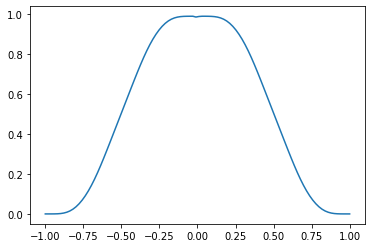

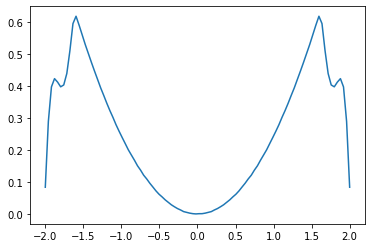

In [7]:
# a few maps

def f(omega, x):
    """
    maps from [-1, 1]x[-1, 1] --> [-1,1]
    parameters:
    omega: a random sample of size 1 drawn from a uniform[-1,1] dist
    x: float in [-1,1]
    output:
    float in [-1,1]: value of mapping of x
    """
    return (x+omega)/2 
    
def f2(omega,x):
    """
    Maps from [-2,2]x[-1,1] --> [-2,2]
    parameters:
    omega: a random sample of size 1 drawn from a uniform[-1,1] dist
    x: float 
    output:
    float in [-2,2] : value of mapping of x 
    """
    return np.cbrt(x+6*omega)


#a few examples
k=100
test=prob_mat(k,f,[-1,1],[-1,1])
mu= stationarydist(test)[0]

test2=prob_mat(k,f2,[-1,1],[-2,2])
mu2 = stationarydist(test2)[0]

# plotting stationary measures
plt.figure()
plt.plot(np.linspace(-1,1,len(mu)),1/np.trapz(np.abs(mu),np.linspace(-1,1,len(mu)))*np.abs(mu))
plt.figure()
plt.plot(np.linspace(-2,2,len(mu2)),1/np.trapz(np.abs(mu2),np.linspace(-2,2,len(mu2)))*np.abs(mu2))



### Alternative method for stationary measures of 1d maps:
#### - quicker but less accurate method to obtain stationary measure by evaluating the Markov kernel at single points


In [8]:
def indicator_fast(x,intervals):
    """
    indicator function
    parameters:
    x  : float array
    intervals  : intervals in R to pass indicator function through
    output:
    2d array of ones and zeros 
    """
    a , b = intervals[:,0][np.newaxis].T, intervals[:,1][np.newaxis].T
    x = np.ndarray.flatten(x)
    out1 = (np.heaviside(x-a,0) - np.heaviside(x-b,0))
    return  out1


def p_fast(x,intervals,f,Ω):
    """
    Markov Kernel 
    parameters:
    x: float array
    intervals: intervals in R to pass indicator function through
    f: function with output: a mapping from Ωxdomain to domain
    Ω: interval in R from which noise values are drawn from uniformly
    output:
    float array
    """
    omega= np.linspace(Ω[0],Ω[1],100)
    x = np.ndarray.flatten(x)
    xs = f(omega,np.transpose([x,]))[0]
    z = indicator_fast(xs,intervals)
    return 1/(Ω[1]-Ω[0])*np.trapz(z,omega,axis=1)


def prob_mat_alt(n,f,n2,Ω,domain):
    """
    Approximates the Perron-Frobenius operator of f by averaging the markov kernel at n3 points inside each subinterval
    parameters:
    n : number of equal subintervals to be created from the domain of f
    f: function with output: mapping from RxR to R, domain of f
    n2 : number of points to average
    output:
    nxn stochastic matrix
    """
    
    #length of each subinterval
    h = (domain[1]-domain[0])/n 
    
    #create partition of the domain of f
    partition = np.linspace(domain[0],domain[1],n+1)
    
    #initialise output matrix
    out = np.zeros((n,n))
    
    #get intervals of domain
    intervals = np.zeros((n,2))
    for j in range(n):
        intervals[j]= partition[j], partition[j+1]
        
    for i in range(n):
        progressbar(i,n)
        
        # stores the values to be averaged
        ave = np.zeros((n2,n))
        
        for j in range(n2):
            x=np.asarray([np.random.uniform(partition[i],partition[i+1])])
            ave[j,:] =p_fast(x,intervals,f,Ω)
            
        out[i,:]= np.mean(ave,axis=0)

    return out

### Examples

(1.0000000000000009+0j)
(1+0j)


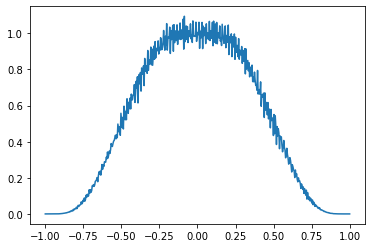

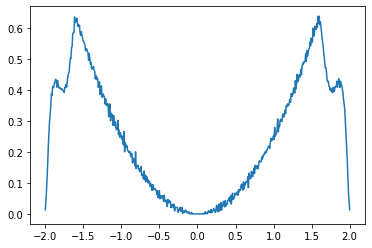

In [9]:
# a few examples
k=500
test3=prob_mat_alt(k,f,1,[-1,1],[-1,1])
z3= stationarydist(test3)[0]

test4=prob_mat_alt(k,f2,1,[-1,1],[-2,2])
z4 = stationarydist(test4)[0]

#plotting
plt.figure()
plt.plot(np.linspace(-1,1,len(z3)),1/np.trapz(np.abs(z3),np.linspace(-1,1,len(z3)))*np.abs(z3))
plt.figure()
plt.plot(np.linspace(-2,2,len(z3)),1/np.trapz(np.abs(z4),np.linspace(-2,2,len(z4)))*np.abs(z4))

# 2D Stationary measures
## Ulam's method:

In [18]:
def indicator_2D(xx,yy,A,B):
    """
    indicator function for R^2
    parameters:
    xx,yy: arrays of x and y coords *of same dimensions
    A: bounds of 'x' coords
    B: bounds of 'y' coords
    output:
    array of ones and zeros 
    """
    a , b = A[0], A[1]
    c , d = B[0], B[1]
    out1 = (np.heaviside(xx-a,0) - np.heaviside(xx-b,0))
    out2 = (np.heaviside(yy-c,0) - np.heaviside(yy-d,0))
    return  np.minimum(out1,out2)

s=1
b=1
def p_2D(xx,yy,A,B,f,Ω,s=s,b=b):
    """
    Markov kernel for R^2
    parameters:
    xx,yy: square meshgrids of same dimensions
    A: bounds of 'x' coord
    B: bounds of 'y' coord
    f: function mapping from Ω x R x R to R x R
    Ω: interval in R from which noise values are drawn form uniformly 
    output:
    float array with shape of xx and yy
    """
    shape = np.shape(xx)
    omega= np.linspace(Ω[0],Ω[1],100)
    xx, yy = np.ndarray.flatten(xx), np.ndarray.flatten(yy)
    xys = f3(omega,np.transpose([xx,]),np.transpose([yy,]),s,b)[0]
    z = indicator_2D(xys[0],xys[1],A,B)
    return np.reshape(1/(Ω[1]-Ω[0])*np.trapz(z,omega,axis=1),shape)

def double_Integral(xmin, xmax, ymin, ymax, nx, ny, A):
    """
    Integration using trapexium rule in 2D taken from: 
    https://stackoverflow.com/questions/20668689/integrating-2d-samples-on-a-rectangular-grid-using-scipy
    parameters:
    xmin, xmax: integral bounds of 'x' coord
    ymin, ymax: integral bounds of 'y' coord
    nx ,ny: number of subintervals of x and y resp.
    A: meshgrid of points to be integrated over
    output:
    float
    """
    dS = ((xmax-xmin)/(nx-1)) * ((ymax-ymin)/(ny-1))
    A_Internal = A[1:-1, 1:-1]
    # sides: up, down, left, right
    (A_u, A_d, A_l, A_r) = (A[0, 1:-1], A[-1, 1:-1], A[1:-1, 0], A[1:-1, -1])
    # corners
    (A_ul, A_ur, A_dl, A_dr) = (A[0, 0], A[0, -1], A[-1, 0], A[-1, -1])
    return dS * (np.sum(A_Internal)\
              + 0.5 * (np.sum(A_u) + np.sum(A_d) + np.sum(A_l) + np.sum(A_r))\
              + 0.25 * (A_ul + A_ur + A_dl + A_dr))

def prob_mat_2D(n,f,Ω,domain):
    """
    Perron-Frobenius operator
    parameters:
    n : integer, n^2 = number of boxes to divide the domain into
    f: function outputting: a map from Ω x domain to domain
    Ω: interval in R from which noise values are drawn form uniformly    
    domain: interval in R^2
    output:
    n^2 x n^2  stochastic matrix
    """
    #area of each cell
    h =(domain[1][1]-domain[1][0])/n*(domain[0][1]-domain[0][0])/n
    partition_x = np.linspace(domain[0][0],domain[0][1],n+1)
    partition_y = np.linspace(domain[1][0],domain[1][1],n+1)
    out = np.zeros((n**2, n**2))
    count=-1
    for k in range(n):
        for l in range(n):
            A2 = (partition_x[k], partition_x[k+1])
            B2 = (partition_y[l], partition_y[l+1])
            x = np.linspace(A2[0], A2[1], 10)
            y = np.linspace(B2[0], B2[1], 10)
            xx,yy = np.meshgrid(x,y)
            count+=1
            count2 = -1
            progressbar(count,n**2)
            for i in range(n):
                for j in range(n):
                    count2 += 1
                    A = (partition_x[i],partition_x[i+1])
                    B = (partition_y[j], partition_y[j+1])
                    zz = p_2D(xx,yy,A,B,f,Ω,s,b)
                    out[count,count2] = double_Integral(A2[0],A2[1],B2[0], B2[1],10,10, zz)/h
            
    return out


def stationarydist_2D(mat):
    """
    gets right eigenvector of input matrix corresponding to evalue 1, reshaped into a 2d matrox
    parameters:
    mat : 2d float array with dimensions n^2 x n^2
    outputs: 2d float array with dimensions n x n
    """
    mat =  sparse.csr_matrix(mat)   
    dim = int(np.sqrt(np.shape(mat)[0]))
    evals,evecs = eigs(np.transpose(mat))
    index = np.argmax(evals)
    
    #check eigenvalue is indeed 1
    print(evals[index])
    
    return np.fliplr((np.abs(np.reshape(evecs[:,index],(dim,dim)))).T)

### Examples

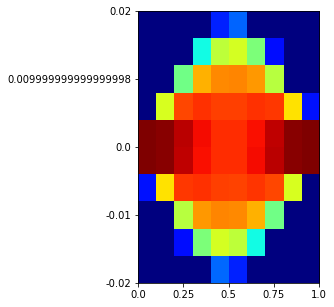

In [21]:
s,b=1,1
def f3(omega,y1,th1,s=s,b=1):
    """ 
    maps from [-1,1]x[-0.022s,0.022s]x[0,1] to [-0.022s,0.022s]x[0,1]
    output constained to a cylinder
    parameters:
    omega: a random sample drawn from uniform[-1,1] dist
    y1: array of 'height' coords   
    th1: array of 'angle' coords
    s,b : floats
    outputs:
    [y1,th1]: value of mapping
#    (-2(s+0.001),2(s+0.001)) : min, max values of domain of mapping of 'x' coord- to be used in later functions
#    (0,1) : min, max values of domain of mapping of 'y' coord- to be used in later functions    
    """
    y1 = y1/2  +s*omega*(np.sin(np.pi*th1)**2+0.1)*0.01
    th1 = np.mod( b*y1+th1,1)
    return [y1,th1], (-2*(s*1.1)*0.01,2*(s*1.1)*0.01), (0,1)
    

test = prob_mat_2D(10,f3,[-1,1],[(-2*(s*1.1)*0.01,2*(s*1.1)*0.01), (0,1)])
d = stationarydist_2D(test)
# plotting
#color maps of approximated stationary measures using log color scale 
fig, ax = plt.subplots(1,1,figsize=(6,5))
img = ax.imshow(d.T,cmap=plt.cm.jet,extent=[-1,1,-1.5,1.5],norm=colors.LogNorm(vmin=1e-4,vmax=np.max(d)))
y_label_list = np.linspace(-0.02*s,0.02*s,5)
x_label_list = np.linspace(0,1,5)
ax.set_yticks(np.linspace(-1.5,1.5,5))
ax.set_xticks(np.linspace(-1,1,5))
ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list);

### Alternative method for stationary measures of 2d maps:
#### - quicker but less accurate method to obtain stationary measure by evaluating the Markov kernel at single points


In [26]:
def indicator_2D_fast(xx,yy,boxes):
    """
    indicator function for R^2
    parameters:
    xx,yy: arrays of x and y coords *of same dimensions
    boxes: intervals in R^2 to pass omdocator function through
    output:
    float array of ones and zeros 
    """
    a , b = boxes[:,0][np.newaxis].T, boxes[:,1][np.newaxis].T
    c , d = boxes[:,2][np.newaxis].T, boxes[:,3][np.newaxis].T
    xx, yy = np.ndarray.flatten(xx), np.ndarray.flatten(yy)
    out1 = (np.heaviside(xx-a,0) - np.heaviside(xx-b,0))
    out2 = (np.heaviside(yy-c,0) - np.heaviside(yy-d,0))
    return  np.minimum(out1,out2)


def p_2D_fast(xx,yy,boxes,f,Ω,s=s,b=b):
    """
    #approximate markov kernel at single point 
    parameters:
    xx,yy: square meshgrid
    boxes: intervals in R^2 to pass omdocator function through
    f: function mapping from ΩxRxR to RxR
    Ω: interval in R from which noise values are drawn form uniformly 
    s,b: parameters for f
    output:
    float array 
    """
    omega= np.linspace(Ω[0],Ω[1],100)
    xx, yy = np.ndarray.flatten(xx), np.ndarray.flatten(yy)
    xys = f(omega,np.transpose([xx,]),np.transpose([yy,]),s,b)[0]
    z = indicator_2D_fast(xys[0],xys[1],boxes)
    return 1/(Ω[1]-Ω[0])*np.trapz(z,omega,axis=1)




def prob_mat_2D_alt(n,f,n2,Ω,domain):
    """
    Perron-Frobenius operator
    parameters:
    n : integer, n^2 = number of boxes to divide the domain into
    f: function outputting: a map from Ω x domain to domain
    n2: integer, number of points to approximate markov kernel from
    Ω: interval in R from which noise values are drawn form uniformly    
    domain: interval in R^2
    output:
    n^2 x n^2  stochastic matrix
    """    
    
    #create partitions
    partition_x = np.linspace(domain[0][0],domain[0][1],n+1)
    partition_y = np.linspace(domain[1][0],domain[1][1],n+1)
    
    #initialise output matrix
    out = np.zeros((n**2, n**2)) 
    
    #get boxes of domain
    boxes = np.zeros((n**2,4))
    count = -1
    for l in range(n):
        for m in range(n):
            count+=1
            boxes[count,:] = (partition_x[l], partition_x[l+1],partition_y[m], partition_y[m+1])
            
            
    for i in range(n**2):
        AB = boxes[i]
        ave = np.zeros((n2,n**2))
        progressbar(i,n**2)
        for j in range(n2):
            x = np.random.uniform(AB[0], AB[1],1)
            y = np.random.uniform(AB[2], AB[3],1) 
            ave[j,:] =p_2D_fast(x,y,boxes,f,Ω,s,b)
        out[i,:]= np.mean(ave,axis=0)
    return out

### Examples:

(1.0000000000000109+0j)


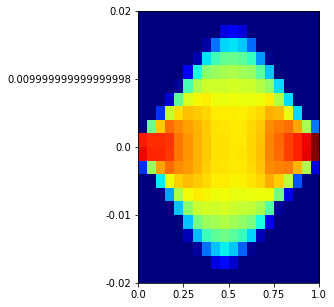

In [31]:
test2 = prob_mat_2D_alt(20,f3,100,[-1,1],[(-2*(s*1.1)*0.01,2*(s*1.1)*0.01), (0,1)])
d2 = stationarydist_2D(test2)

# plotting
#color maps of approximated stationary measures using log color scale 
fig, ax = plt.subplots(1,1,figsize=(6,5))
img = ax.imshow(d2.T,cmap=plt.cm.jet,extent=[-1,1,-1.5,1.5],norm=colors.LogNorm(vmin=1e-4,vmax=np.max(d2)))
y_label_list = np.linspace(-0.02*s,0.02*s,5)
x_label_list = np.linspace(0,1,5)
ax.set_yticks(np.linspace(-1.5,1.5,5))
ax.set_xticks(np.linspace(-1,1,5))
ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list);

# Quasi-stationary measures

## Ulam's method:

### Example:

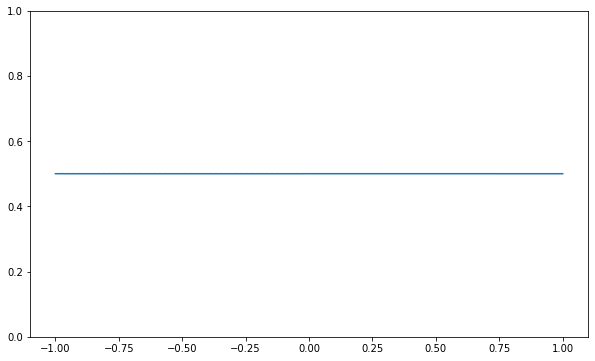

In [34]:
#QSDs can also be computed using Ulam's method

#eg

def g(omega,x):
    """
    maps from [-1,1]x[-1,1] to [-1,1] with escape
    parameters:
    omega: a random sample of size 1 drawn from a uniform[-1,1] dist
    x: float in [-1,1]
    output:
    float : value of mapping of x
    """
    return 2*x + omega


k=200
omega=np.random.uniform(-1,1,size=k)
test=prob_mat(k,g,[-1,1],[-1,1])
z,lmda= stationarydist(test)
print(lmda)
plt.figure(figsize=(10,6))
plt.plot(np.linspace(-1,1,len(z)),1/np.trapz(np.abs(z),np.linspace(-1,1,len(z)))*np.abs(z))
plt.ylim([0,1]);

## Monte Carlo method:

In [52]:
# Monte Carlo method for QSD
def MCQSD(g,N,N2,Ω,domain):
    '''
    parameters: 
    g  : function mapping from Ω x domain --> R
    domain  : 1D interval
    N  : integer - length of trajectory  
    N2  : integer - number of subintervals to divide domain into
    output:
    count  : QSD
    survivals  : Survival rate of QSM
    '''
    partition = np.linspace(domain[0],domain[1],N2+1)
    
    #initalize output
    count=np.zeros(N2)
    
    
    #list of previous points of trajectory inside domain
    x_tracker=np.zeros(N+1)
    x_tracker[0] = np.random.uniform(domain[0],domain[1])
    
    #store killing times
    killing_times=[0]
    
    intervals = np.zeros((N2,2))
    for j in range(N2):
        intervals[j]= partition[j], partition[j+1]
    
    
    for n in range(N):
        #print percentage of for loops completed
        progressbar(n,N)
        
        #move trajectory forward one timestep 
        newx = g(np.random.uniform(Ω[0],Ω[1]),x_tracker[n])
        
        #find out which subinterval the new point lies, if any 
        add =  np.ndarray.flatten(indicator_fast(np.asarray([newx]),intervals))
        
        #record point's location (in domain)
        count += add
        
        #if point lies outside domain, resample from empirical distribution
        if np.sum(add)==0:
            killing_times.append(n+1)
            x_tracker[n+1] = x_tracker[int(n*np.random.uniform(0,1))]
        
        else:
            x_tracker[n+1] = newx
    #calculate survival rate        
    survivals = np.mean([killing_times[i+1]-killing_times[i] for i in range(len(killing_times)-1)])
    
    #calculate aprroximate QSD
    count = count/(N*((partition[1]-partition[0])**2))
    return count, survivals    

### Examples:

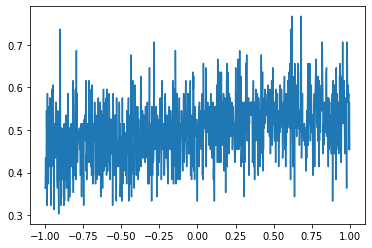

In [54]:
#plotting example
test = MCQSD(g, 10**5,1000,[-1,1],[-1,1])
plt.plot(np.linspace(-1,1,len(test[0])),test[0]/np.trapz(test[0],np.linspace(-1,1,len(test[0]))))
plt.show()


# Top Lyapunov exponent 

## Method 1 using stationary measures


In [40]:
def top_lyap(μ, E, Ω, M):
    """
    parameters:
    μ : stationary measure of a 1d map f : Ω x M to M
    E : map E_w(ln|df/dx)|) from Ω x R to R
    Ω : interval in R from which noise values are drawn uniformly
    M : interval in R
    output:
    float
    """
    #normalize μ 
    μ = np.abs(μ)/np.sum(μ)
    res = len(μ)
    
    x = np.linspace(M[0], M[1], res)
    if Ω[0] == 0:
        g = 1/(Ω[1]-Ω[0])*(E(Ω[1],x))
    else:
        g = 1/(Ω[1]-Ω[0])*(E(Ω[1],x)-E(Ω[0],x))
        
    y = g*μ
    
    return np.sum(y)  


### Examples:

In [55]:
# example for a random logistic map

def f4(w,x):
    """
    map from Ω ⊆ [0,4] x [0,1] to [0,1]
    parameters:
    w: float in Ω
    x: float array in [0,1]
    output:
    float array
    """
    return w*x*(1-x)

def exp_f4(w,x):
    """
    E_w(ln|df/dx)|) - calculated using online integration calculator - map from Ω ⊆ [0,4] x R to R 
    """
    return 0.5*w*((np.sign(w-2*x*w)+1)*(np.log(abs(w-2*x*w))-1) -((np.sign(w-2*x*w)-1))*(np.log(abs(2*x-1)*w)-1))

mu = MCQSD(f4,10**5,1000,[1.75,4],[0,1])[0]
print(top_lyap(mu, exp_f4, [1.75,4], [0,1]))

n=400
test = prob_mat(n,f4,[1.75,4],[0,1])
mu_ulam = stationarydist(test)[0]
print(top_lyap(mu_ulam, exp_f4, [1.75,4], [0,1]))

-0.3699426745430838
(0.9900211625877922+0j)
(-0.36269462900325544+0j)


## Method 2 approximating the Birkhoff sums


In [56]:
def birkhoff(f,diff_f,n,Ω,domain):
    """
    approximates Birkhoff sum for top Lyapunov exponent
    parameters:
    f: map from Ω x domain to domain
    diff_f: partial derivative of f w.r.t. x
    n: integer >> 1
    Ω: interval in R from which noise values are drawn from uniformly
    domain: interval in R
    """
    omega = np.random.uniform(Ω[0],Ω[1],n+1)
    birk_sum = 0
    phi_i = np.random.uniform(domain[0],domain[1])
    for i in range(n):
        phi_i = f(omega[i],phi_i)
        birk_sum += np.log(abs(diff_f(omega[i],phi_i)))
    return birk_sum/n

### Example:

In [57]:
def df4_dx(w,x):
    return w-2*w*x
    
birkhoff(f4,df4_dx,1000000,[1.75,4],[0,1])

-0.3681525270935276

# Conditional Lyapunov exponents


In [58]:
# For maps with escape
#  First compute quasi ergodic measure using transition matrix found via Ulam's method
def QEM(mat):
    mat = sparse.csr_matrix(mat)   
    evals,evecs = eigs(np.transpose(mat))
    evals2,evecs2 = eigs(mat)
    index = np.argmax(evals)
    index2 = np.argmax(evals2)
    return evecs[:,index]*evecs2[:,index2]


def cond_lyap(qem, E, Ω, M):
    qem = np.abs(qem)/np.sum(qem)
    res = len(qem)
    x = np.linspace(M[0], M[1], res)

    if Ω[0] == 0:
        g = 1/(Ω[1]-Ω[0])*(E(Ω[1],x))
    else:
        g = 1/(Ω[1]-Ω[0])*(E(Ω[1],x)-E(Ω[0],x))

    y = g*qem
    return np.sum(y)  

### Example:

In [61]:
def exp_g(w,x):
    return w*np.log(2)

test= prob_mat(200,g,[-1,1],[-1,1])
q=QEM(test)
cond_lyap(q,exp_g,[-1,1],[-1,1])

(0.6931471805599454+0j)